## Regress out cell counts from all features

In [1]:
import sys
sys.path.append('../1.load')

import numpy as np
import pandas as pd

from preprocess import preprocess_profiles, config
from correct_position_effect import subtract_well_mean, mad_robustize_col, regress_out_cell_counts

from matplotlib import pyplot as plt

#### Load a subset of profiles and merge cell counts

In [2]:
CC_MERGE_COLS = ["Metadata_JCP2022", "Metadata_Plate", "Metadata_Well"]
CC_COL = "Metadata_Count_Cells"
CC_COL_NEW = "Cells_Count"

RELAXED_FEATURE_SELECT = {"unique_cut": 0.05}

In [3]:
cc_metadata = pd.read_parquet("../1.load/output/subset_profiles_cc_metadata.parquet")
cc_metadata

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,Metadata_Insert_Length,Metadata_pert_type,Metadata_Source,Metadata_Plate,Metadata_Well,Metadata_Plate_Map_Name,Metadata_Count_Cells
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,1584.0,trt,source_4,BR00126538,B21,OAB37.38.39.40.A,1151
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,2529.0,trt,source_4,BR00126538,I15,OAB37.38.39.40.A,1245
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,888.0,trt,source_4,BR00126538,K21,OAB37.38.39.40.A,1140
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,2280.0,trt,source_4,BR00126538,L17,OAB37.38.39.40.A,1220
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,2238.0,trt,source_4,BR00126538,L20,OAB37.38.39.40.A,1072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,1650.0,negcon,source_4,BR00123791,M12,OAB41.OAC17.OAB78.79.A,1035
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,3204.0,negcon,source_4,BR00123791,F17,OAB41.OAC17.OAB78.79.A,1203
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,3204.0,negcon,source_4,BR00123791,I10,OAB41.OAC17.OAB78.79.A,1154
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,3204.0,negcon,source_4,BR00123791,K09,OAB41.OAC17.OAB78.79.A,1179


In [4]:
ann_profiles = pd.read_parquet("../1.load/output/subset_profiles.parquet")
ann_profiles = ann_profiles.merge(cc_metadata[CC_MERGE_COLS + [CC_COL]], on=CC_MERGE_COLS)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Plate_Map_Name,Metadata_Count_Cells
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,46.077000,46.318001,46.028999,46.393002,46.639000,47.831001,46.651001,48.021000,OAB37.38.39.40.A,1151
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,57.683998,58.122002,57.683998,58.137001,58.535999,60.215000,58.625999,60.560001,OAB37.38.39.40.A,1245
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,40.491001,40.872002,40.462002,40.923000,41.264000,42.422001,41.236000,42.514000,OAB37.38.39.40.A,1140
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,49.242001,49.653000,49.251999,49.708000,50.063999,51.639999,50.113998,51.570000,OAB37.38.39.40.A,1220
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,52.728001,53.193001,52.875999,53.160000,53.438000,54.987999,53.695000,55.131001,OAB37.38.39.40.A,1072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,28.951000,29.181999,29.153999,29.162001,29.171000,30.061001,29.388000,29.938000,OAB41.OAC17.OAB78.79.A,1035
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,32.294998,32.636002,32.362000,32.466000,32.683998,33.604000,32.743999,33.476002,OAB41.OAC17.OAB78.79.A,1203
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,28.872999,29.042000,28.905001,29.143999,29.282000,30.084999,29.292000,30.077000,OAB41.OAC17.OAB78.79.A,1154
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,31.473000,31.583000,31.374001,31.563999,31.844000,32.480000,31.665001,32.480999,OAB41.OAC17.OAB78.79.A,1179


#### Regress each feature on cell counts and store the residuals

In [5]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL, cc_rename=CC_COL_NEW)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_Variance_RNA_3_00_256,Nuclei_Texture_Variance_RNA_3_01_256,Nuclei_Texture_Variance_RNA_3_02_256,Nuclei_Texture_Variance_RNA_3_03_256,Nuclei_Texture_Variance_RNA_5_00_256,Nuclei_Texture_Variance_RNA_5_01_256,Nuclei_Texture_Variance_RNA_5_02_256,Nuclei_Texture_Variance_RNA_5_03_256,Metadata_Plate_Map_Name,Cells_Count
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,-20.348539,-20.629281,-20.367806,-20.649965,-20.883736,-21.518449,-20.845304,-21.408078,OAB37.38.39.40.A,1151
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-5.480802,-5.539155,-5.454112,-5.611072,-5.670324,-5.736946,-5.556997,-5.461195,OAB37.38.39.40.A,1245
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-26.316114,-26.459826,-26.316141,-26.505539,-26.646827,-27.325030,-26.648032,-27.313873,OAB37.38.39.40.A,1140
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-14.790017,-14.882126,-14.752785,-14.916374,-15.024349,-15.215539,-14.950197,-15.357548,OAB37.38.39.40.A,1220
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-16.437947,-16.516024,-16.259498,-16.652079,-16.871934,-17.216801,-16.585894,-17.162148,OAB37.38.39.40.A,1072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-41.498430,-41.820501,-41.264176,-41.947005,-42.444331,-43.481114,-42.197068,-43.696549,OAB41.OAC17.OAB78.79.A,1035
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-32.326728,-32.493423,-32.232123,-32.754260,-33.004127,-33.865980,-32.919411,-34.067865,OAB41.OAC17.OAB78.79.A,1203
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-37.448474,-37.800405,-37.387804,-37.793811,-38.134894,-39.156020,-38.098561,-39.243316,OAB41.OAC17.OAB78.79.A,1154
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-33.981255,-34.385436,-34.052130,-34.497510,-34.690869,-35.857428,-34.844361,-35.932965,OAB41.OAC17.OAB78.79.A,1179


#### Check if cell count has correlation above 0.5 with any feature

In [6]:
for feature in ann_profiles.filter(regex="^(?!Metadata_)").columns:
    feature_corr = ann_profiles["Cells_Count"].corr(ann_profiles[feature])
    if feature_corr > 0.5:
        print(f"{feature}: {ann_profiles.Cells_Count.corr(ann_profiles[feature])}")

Image_ImageQuality_Scaling_OrigAGP: 0.7990324803970476
Image_ImageQuality_Scaling_OrigDNA: 0.7990324803970476
Image_ImageQuality_Scaling_OrigER: 0.7990324803970476
Image_ImageQuality_Scaling_OrigMito: 0.7990324803970476
Image_ImageQuality_Scaling_OrigRNA: 0.7990324803970476
Cells_Count: 1.0


#### Plot the ratio of unique values / size for cell count

This is the reason it gets filtered by `feature_select`

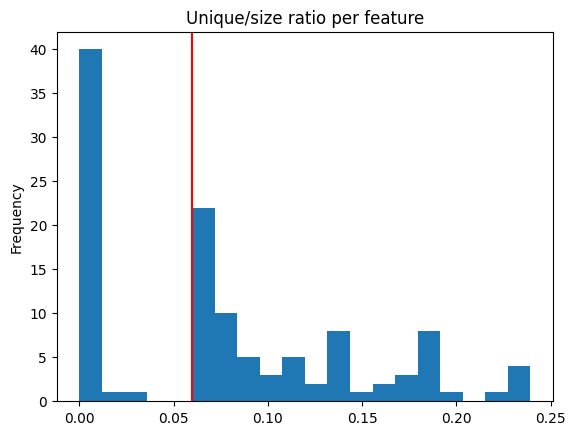

In [7]:
unique_ratio = ann_profiles.nunique() / ann_profiles.shape[0]
unique_ratio[unique_ratio<0.3].plot(kind="hist", bins=20, title="Unique/size ratio per feature")
plt.axvline(x=unique_ratio["Cells_Count"], color="red")

#### Preprocess with lowered threshold for unique values and save CC-corrected subset

In [8]:
ann_profiles_processed = preprocess_profiles(ann_profiles, feature_select_kwargs=RELAXED_FEATURE_SELECT)
ann_profiles_processed

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Cells_Count
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.076629,0.320495,-0.385691,0.190393,0.455439,0.509989,-1.019058,-0.728018,-0.842900,0.470287
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-1.089465,-0.339287,-1.516528,-0.441853,-0.130403,-0.575900,0.593813,0.509472,-0.214630,1.051958
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.754398,0.077711,-0.322006,0.405521,0.628356,0.367091,0.264900,-0.726229,-0.754226,0.402219
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.494212,-0.287738,-0.628006,-0.710360,-0.637044,-0.199234,-0.135215,-0.290255,0.329603,0.897258
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.722263,-0.448482,-1.166396,-1.939791,-1.753126,-0.387831,-0.074344,0.047114,1.303154,-0.018564
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-3.969020,-0.809173,-2.974404,-2.787182,-0.704466,0.198940,2.073704,0.223352,-0.531671,-0.247520
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.094050,-0.711135,-2.103393,-1.919127,-0.485729,0.300176,1.795613,-0.029494,-0.503798,0.792063
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.648240,-0.653903,-2.628677,-2.837781,-0.915236,0.115573,2.372484,0.350838,0.082462,0.488851
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-4.202986,-0.806160,-2.797058,-2.398970,-0.965612,0.605841,2.384358,0.194635,0.017635,0.643551


In [9]:
# check that the cell count column is still there
assert CC_COL_NEW in ann_profiles_processed.columns

ann_profiles_processed.to_parquet("output/subset_profiles_cc_corrected.parquet")
del ann_profiles_processed

#### Apply well mean subtraction, preprocess and save

In [10]:
ann_profiles = subtract_well_mean(ann_profiles)
ann_profiles = preprocess_profiles(ann_profiles, feature_select_kwargs=RELAXED_FEATURE_SELECT)
ann_profiles.to_parquet("output/subset_profiles_cc_well_corrected.parquet")
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_SumVariance_AGP_5_01_256,Cells_Count
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.112042,0.722820,-0.542878,0.445819,0.554633,0.000246,-0.777673,-0.271556,-0.301070,0.302979
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.859927,-0.216504,-1.635898,-0.594053,-0.245424,-0.384197,0.320188,0.534347,-0.265611,1.447591
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.284880,0.654772,-0.385083,0.738852,0.778439,0.157445,0.227132,-0.378389,-0.490796,0.567640
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.186934,-0.008743,-0.695323,-0.444192,-0.444712,-0.123820,-0.066552,-0.135714,-0.355337,1.116396
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.443297,0.014899,-1.215245,-1.526079,-1.410069,-0.958717,-0.034017,0.286270,-0.107739,0.224152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19139,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-3.650269,-0.848690,-2.937236,-2.436438,-0.436381,0.461984,2.106191,0.340590,-0.859667,1.138955
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.749796,-0.259789,-2.186415,-1.711162,-0.142883,0.290334,1.651752,-0.077586,-0.304493,0.647735
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.759512,-0.895225,-2.655379,-3.027403,-1.034180,0.781016,2.484165,0.176254,-0.158996,1.447043
19142,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-4.787423,-1.019240,-3.183991,-3.002272,-1.290461,1.253938,2.805805,0.129172,-0.161503,0.943112


#### Regress out cell count from the preprocessed subset

In [11]:
cc_metadata = pd.read_parquet("../1.load/output/subset_profiles_cc_metadata.parquet")
ann_profiles = pd.read_parquet("../1.load/output/subset_processed_profiles.parquet")
ann_profiles = ann_profiles.merge(cc_metadata[CC_MERGE_COLS + [CC_COL]], on=CC_MERGE_COLS)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Metadata_Count_Cells
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,-0.347879,0.571561,0.233940,0.605959,0.578546,-1.184907,-0.998695,-0.876162,-1.057291,1151
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-1.433294,-0.133203,-0.359655,0.173131,-0.434340,0.301239,-0.317683,0.198563,-0.642222,1245
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.288633,0.636346,0.443830,0.758651,0.430319,0.111316,-0.399199,-0.859052,-0.949307,1140
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.564355,0.445624,-0.636230,-0.359488,-0.078135,-0.393562,-0.187257,-0.545916,-0.066014,1220
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-1.144660,-0.064180,-1.915246,-1.671197,-0.359077,-0.137696,0.141607,-0.010367,1.174983,1072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.941786,-1.063807,-2.772297,-0.700941,0.197062,2.055386,-0.084778,0.213081,-0.520736,1035
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.026512,-0.405664,-1.845284,-0.236853,0.404465,1.556313,-0.197505,-0.268032,-0.835836,1203
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.561244,-0.951796,-2.777763,-0.729796,0.190742,2.196773,-0.121577,0.171086,-0.170204,1154
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.719235,-1.129803,-2.331747,-0.741819,0.691152,2.175670,-0.253400,-0.016072,-0.283672,1179


In [12]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL, cc_rename=CC_COL_NEW)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_03_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_DNA_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Cells_Count
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,-0.338434,0.434018,0.316296,0.449249,0.467342,-0.806398,-0.693621,-0.419014,-0.599807,1151
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-1.454826,-0.374529,-0.312747,-0.123587,-0.605621,0.803648,0.163977,0.787039,0.006647,1245
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.275563,0.510948,0.530334,0.618325,0.326145,0.475325,-0.114789,-0.417272,-0.514219,1140
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.577648,0.231900,-0.579894,-0.618970,-0.233438,0.075895,0.247439,0.007632,0.531955,1220
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-1.109182,-0.114502,-1.803099,-1.710241,-0.419790,0.136683,0.298273,0.336410,1.471622,1072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-2.894114,-1.073278,-2.646198,-0.684874,0.159997,2.280996,0.002381,0.508166,-0.299430,1035
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.034203,-0.600619,-1.782537,-0.471014,0.260027,2.003362,0.205255,0.261765,-0.272480,1203
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.552787,-1.092651,-2.696538,-0.890974,0.077621,2.579236,0.189132,0.632425,0.293387,1154
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.719017,-1.298260,-2.259950,-0.940233,0.562053,2.591085,0.104274,0.480195,0.230820,1179


In [13]:
ann_profiles[CC_COL_NEW] = mad_robustize_col(ann_profiles[CC_COL_NEW], epsilon=config["MAD_EPSILON"])

In [14]:
ann_profiles.to_parquet("output/subset_processed_cc_corrected.parquet")

#### Regress out cell count from the preprocessed and corrected dataset

In [15]:
ann_profiles = pd.read_parquet("output/subset_profiles_mean_corrected_preprocessed.parquet")
ann_profiles = ann_profiles.merge(cc_metadata[CC_MERGE_COLS + [CC_COL]], on=CC_MERGE_COLS)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Metadata_Count_Cells
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.146819,0.819576,-0.509169,0.472318,0.642681,0.066633,-0.881860,-0.350066,-1.073529,1151
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.727536,0.174183,-1.533901,-0.491498,0.133856,-0.166967,-0.046219,0.143956,-0.708162,1245
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.227209,0.816750,-0.338482,0.779559,0.923186,0.256518,0.053587,-0.516253,-1.248180,1140
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.083525,0.298071,-0.617495,-0.362687,-0.138488,0.048434,-0.356286,-0.416854,-0.335360,1220
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.414073,0.105622,-1.180956,-1.491862,-1.289506,-0.893941,-0.129673,0.202546,0.657406,1072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-3.538450,-0.520974,-2.842374,-2.340930,-0.125043,0.631924,1.786284,0.033267,-0.950689,1035
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.680781,-0.061632,-2.122849,-1.650066,0.044767,0.398538,1.444183,-0.247909,-1.030216,1203
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.621706,-0.492188,-2.546204,-2.909455,-0.634502,0.987795,2.092715,-0.198424,-0.264739,1154
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-4.689853,-0.735725,-3.097747,-2.915065,-1.003161,1.391602,2.520438,-0.121587,-0.152909,1179


In [16]:
ann_profiles = regress_out_cell_counts(ann_profiles, CC_COL, cc_rename=CC_COL_NEW)
ann_profiles

,Metadata_JCP2022,Metadata_broad_sample,Metadata_Name,Metadata_Vector,Metadata_Transcript,Metadata_Symbol,Metadata_NCBI_Gene_ID,Metadata_Taxon_ID,Metadata_Gene_Description,Metadata_Prot_Match,...,Nuclei_Texture_InfoMeas1_AGP_5_02_256,Nuclei_Texture_InfoMeas1_DNA_3_00_256,Nuclei_Texture_InfoMeas1_ER_3_00_256,Nuclei_Texture_InfoMeas1_Mito_3_03_256,Nuclei_Texture_InfoMeas1_Mito_5_03_256,Nuclei_Texture_InfoMeas1_RNA_3_00_256,Nuclei_Texture_InfoMeas2_AGP_3_00_256,Nuclei_Texture_InfoMeas2_ER_3_00_256,Nuclei_Texture_InfoMeas2_Mito_3_00_256,Cells_Count
0,JCP2022_900006,ccsbBroad304_00008,ORF000425.1_TRC304.1,pLX_304,NM_001095.4,ASIC1,41,9606,acid sensing ion channel subunit 1,100.0,...,0.208086,0.726469,-0.509488,0.595821,0.507878,-0.278576,-0.477156,0.173326,-0.640039,1151
1,JCP2022_900176,ccsbBroad304_00189,ORF011559.1_TRC304.1,pLX_304,NM_000587.4,C7,730,9606,complement C7,100.0,...,-0.704611,-0.051392,-1.573745,-0.382199,-0.115360,-0.596267,0.486543,0.811490,-0.107146,1245
2,JCP2022_900198,ccsbBroad304_00212,ORF000189.1_TRC304.1,pLX_304,NM_001745.4,CAMLG,819,9606,calcium modulating ligand,100.0,...,-0.161455,0.739145,-0.334176,0.904724,0.801771,-0.078850,0.443306,-0.009728,-0.834294,1140
3,JCP2022_900294,ccsbBroad304_00321,ORF012872.1_TRC304.1,pLX_304,NM_001830.4,CLCN4,1183,9606,chloride voltage-gated channel 4,100.0,...,-0.050404,0.107727,-0.646828,-0.249610,-0.357276,-0.358501,0.142418,0.212344,0.221102,1220
4,JCP2022_900295,ccsbBroad304_00322,ORF012041.1_TRC304.1,pLX_304,NM_000084.5,CLCN5,1184,9606,chloride voltage-gated channel 5,100.0,...,-0.320582,0.123846,-1.148057,-1.356421,-1.328154,-1.168477,0.167408,0.604798,0.950103,1072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19138,JCP2022_915130,ccsbBroad304_99991,ORFC00003.1_TRC304.1,pLX_304,promegaLuc.1,LUCIFERASE,LUCIFERASE,CONTROL,promegaLuc,100.0,...,-3.429867,-0.450608,-2.793918,-2.199899,-0.118656,0.390487,2.032960,0.378783,-0.723933,1035
19139,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-2.640725,-0.228019,-2.145033,-1.534421,-0.153329,0.006811,1.919728,0.355222,-0.504052,1203
19140,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-3.561662,-0.589522,-2.547785,-2.786405,-0.772957,0.639903,2.501507,0.329568,0.174098,1154
19141,JCP2022_915131,ccsbBroad304_99994,ORFC00004.1_TRC304.1,pLX_304,LacZ.1,LacZ,LacZ,CONTROL,Hahn Lab LacZ,100.0,...,-4.640008,-0.868290,-3.109840,-2.795793,-1.172045,1.021345,2.963287,0.444741,0.330482,1179


In [17]:
ann_profiles[CC_COL_NEW] = mad_robustize_col(ann_profiles[CC_COL_NEW], epsilon=config["MAD_EPSILON"])

In [18]:
ann_profiles.to_parquet("output/subset_mean_corrected_processed_cc_corrected.parquet")